In [1]:
# 행렬 연산을 어떤 device에서 할지.
import torch
import torch.nn.init
import numpy as np
import os
import random

device = None
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# 일정한 실험을 위해 랜덤 시드 고정
seed = 777
torch.cuda.manual_seed_all(seed) 
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

print('Current Device : ' + str(device))

Current Device : mps


In [2]:
# MNIST 데이터셋 고정
import os
import torchvision.transforms as transforms # MNIST 데이터를 텐서 형태로 바꾸기 위해
import torchvision.datasets as dsets # 이 안에 MNIST 있다

if os.path.exists('MNIST'):
    print('There is MNIST data.')
    train_raw = dsets.MNIST(root=str(os.getcwd()), train=True, transform=transforms.ToTensor(), download=False)
    test_raw = dsets.MNIST(root=str(os.getcwd()), train=False, transform=transforms.ToTensor(), download=False)
    # train_raw = dsets.MNIST(root=str(os.getcwd()), train=True, download=False)
    # test_raw = dsets.MNIST(root=str(os.getcwd()), train=False, download=False)
else: # MNIST 데이터 다운로드
    print('There is no MNIST data.')
    train_raw = dsets.MNIST(root=str(os.getcwd()), train=True, transform=transforms.ToTensor(), download=True)
    test_raw = dsets.MNIST(root=str(os.getcwd()), train=False, transform=transforms.ToTensor(), download=True)

print(train_raw)
print(test_raw)

There is MNIST data.
Dataset MNIST
    Number of datapoints: 60000
    Root location: /Users/ljs/NODE
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: /Users/ljs/NODE
    Split: Test
    StandardTransform
Transform: ToTensor()


In [3]:
# MNIST 데이터셋을 원하는 레벨로 양자화 시켜 새로운 데이터셋을 만든다.

from torch.utils.data import Dataset

class Customdataset(Dataset):
    def __init__(self, dataset:dsets.MNIST, quantization_level = 10) -> None:
        super(Customdataset, self).__init__()
        self.origin_dataset = dataset
        self.quantization_level = quantization_level
        return None
    
    def quantize_tensor(self, tensor:torch.Tensor, levels:int) -> torch.Tensor:
        min_value = tensor.min()
        max_value = tensor.max()
        quantized_tensor = tensor.clone()
        quantized_tensor.sub_(min_value).div_(max_value - min_value + 1e-5).mul_(levels - 1).round_().div_(levels - 1).mul_(max_value - min_value + 1e-5).add_(min_value)
        return quantized_tensor

    def __len__(self):
        return len(self.origin_dataset) # 데이터셋 크기는 양자화 해도 그대로.

    def __getitem__(self, idx:int) -> tuple[torch.Tensor, torch.Tensor]:
        data, label = self.origin_dataset[idx]
        modified_data = self.quantize_tensor(data, self.quantization_level)
        return modified_data, label
        # return torch.from_numpy(self.x[idx]), torch.from_numpy(self.y[idx])

train_custom = Customdataset(train_raw, quantization_level=10)
test_custom = Customdataset(test_raw, quantization_level=10)


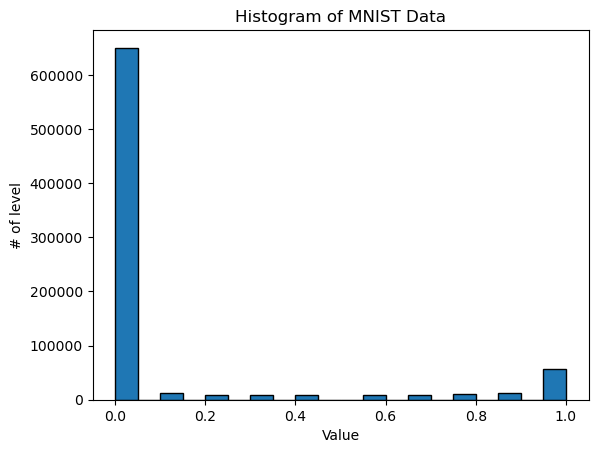

In [4]:
# 데이터에서 어떤 레벨의 값들이 많은지 확인
import numpy as np
import matplotlib.pyplot as plt

temp = np.zeros(1)
for idx, (data,label) in enumerate(test_custom):
    temp = np.append(temp, data.view(-1).numpy())
    if idx == 1000: break # 1000개만. 너무 많으면 동작 멈춰버리는듯?

plt.hist(temp, bins=20, edgecolor='black') # Plot the histogram with 20 bins and black edges
plt.title('Histogram of MNIST Data') # Add title to the plot
plt.xlabel('Value') # Label the x-axis
plt.ylabel('# of level') # Label the y-axis
plt.show() # Display the plot
# 100개 데이터에 대해 확인해보았더니, 0,1 레벨 값이 제일 많더라.
# 2개 레벨로 줄여버려야지.

In [6]:
# 데이터셋 양자화 레벨 2로 조정 및 데이터로더 생성
BATCH_SIZE = 100
train_custom = Customdataset(train_raw, quantization_level=2)
test_custom = Customdataset(test_raw, quantization_level=2)
train_loader = torch.utils.data.DataLoader(dataset=train_custom, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=test_custom, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# 데이터 로더 동작 확인
for x,y in train_loader:
    print('입력 데이터 형태: ', x.shape)
    print('정답 데이터 형태: ', y.shape)
    break


입력 데이터 형태:  torch.Size([100, 1, 28, 28])
정답 데이터 형태:  torch.Size([100])


In [30]:
# 양자화 시킨 데이터셋을 적용시킬 CR+FC 뉴럴네트워크 생성
import torch.nn as nn
from torchinfo import summary

class CRFC(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        IMG_WIDTH = 28
        COL_CH = 2
        ROW_CH = 2
        self.col1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(IMG_WIDTH,1), bias=False) # MINST : 흑백이미지 -> 채널=1
        self.col2 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(IMG_WIDTH,1), bias=False)
        self.row1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(1,IMG_WIDTH), bias=False)
        self.row2 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(1,IMG_WIDTH), bias=False)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(IMG_WIDTH, 10, bias=False) # MNIST 답 선택지 개수=10
        self.fc2 = nn.Linear(IMG_WIDTH, 10, bias=False)
        self.fc3 = nn.Linear(IMG_WIDTH, 10, bias=False)
        self.fc4 = nn.Linear(IMG_WIDTH, 10, bias=False)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, input:torch.Tensor, quantize=False) -> torch.Tensor:
        h1 = self.col1(input).squeeze() # (BATCH_SIZE, COL_CH, 1, IMG_WIDTH) 에서 1인 차원 제거 
        h1 = self.relu(h1)
        h1 = self.fc1(h1) # torch.Size([[BATCH_SIZE, COL_CH, 10])

        h2 = self.col2(input).squeeze()
        h2 = self.relu(h2)
        h2 = self.fc2(h2)

        h3 = self.row1(input).squeeze()
        h3 = self.relu(h3)
        h3 = self.fc3(h3)

        h4 = self.row2(input).squeeze()
        h4 = self.relu(h4)
        h4 = self.fc4(h4)

        h5 = h1 + h2 + h3 + h4
        # h5 = torch.sum((h1,h2,h3,h4), dim=1)
        output = self.softmax(h5)
        return output

# 모델 객체 생성
model = CRFC()

# 컨볼루션 테스트 
for x, y in train_loader:
    output = model(x)
    break
print('output: ', output.shape)

# 모델 구조 확인
summary(model, (100,1,28,28))

output:  torch.Size([100, 10])


Layer (type:depth-idx)                   Output Shape              Param #
CRFC                                     [100, 10]                 --
├─Conv2d: 1-1                            [100, 1, 1, 28]           28
├─ReLU: 1-2                              [100, 28]                 --
├─Linear: 1-3                            [100, 10]                 280
├─Conv2d: 1-4                            [100, 1, 1, 28]           28
├─ReLU: 1-5                              [100, 28]                 --
├─Linear: 1-6                            [100, 10]                 280
├─Conv2d: 1-7                            [100, 1, 28, 1]           28
├─ReLU: 1-8                              [100, 28]                 --
├─Linear: 1-9                            [100, 10]                 280
├─Conv2d: 1-10                           [100, 1, 28, 1]           28
├─ReLU: 1-11                             [100, 28]                 --
├─Linear: 1-12                           [100, 10]                 280
├─Softmax: 

In [34]:
# 모델 학습
from tqdm import tqdm

EPOCH = 3
LR = 1e-3
L2_LAMBDA = 1e-3

model.to(device)
cross_entropy = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

accum_loss = 0 
train_loss_arr = []
test_loss_arr = []
acc_arr = []
accum_acc = 0

for epoch in range(EPOCH):
    model.train()
    with tqdm(total=len(train_loader), desc='Train') as pbar:
        for x,y in train_loader:
            train_output = model(x.to(device))
            # l2_norm = sum(param.pow(2.0).sum() for param in model.parameters())
            # train_loss = cross_entropy(train_output, y.to(device)) + (L2_LAMBDA * l2_norm)
            train_loss = cross_entropy(train_output, y.to(device))
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            accum_loss += train_loss.cpu().item()
            pbar.update(1)
    cur_train_loss = accum_loss/len(train_loader)
    train_loss_arr.append(cur_train_loss)
    accum_loss = 0

    model.eval()
    with torch.no_grad():
        with tqdm(total=len(test_loader), desc='Evaluation') as pbar:
            for x,y in test_loader:
                test_output = model(x.to(device))
                # l2_norm = sum(param.pow(2.0).sum() for param in model.parameters())
                # test_loss = cross_entropy(test_output, y.to(device)) + (L2_LAMBDA * l2_norm)
                test_loss = cross_entropy(test_output, y.to(device))
                accum_loss += test_loss.cpu().item()
                max_prob, pred_idx = torch.max(test_output.data, 1)
                accum_acc += (pred_idx.cpu() == y).sum().item()
                pbar.update(1)
    cur_test_loss = accum_loss/len(test_loader)
    test_loss_arr.append(cur_test_loss)
    cur_acc = 100*accum_acc/len(test_loader.dataset)
    acc_arr.append(cur_acc)
    accum_loss = 0
    accum_acc = 0
    print("Epoch [{}/{}] Train_Loss: {:.4f}, Test_Loss: {:.4f}, Test_acc: {:.2f}".format(epoch+1, EPOCH, cur_train_loss,cur_test_loss, cur_acc))





Evaluation: 100%|██████████| 100/100 [00:01<00:00, 63.24it/s]


Epoch [1/3] Train_Loss: 1.5600, Test_Loss: 1.5553, Test_acc: 91.20


Evaluation: 100%|██████████| 100/100 [00:01<00:00, 62.18it/s]


Epoch [2/3] Train_Loss: 1.5586, Test_Loss: 1.5553, Test_acc: 91.03


Evaluation: 100%|██████████| 100/100 [00:01<00:00, 65.03it/s]

Epoch [3/3] Train_Loss: 1.5574, Test_Loss: 1.5539, Test_acc: 91.06


In [88]:
param_arr = []
for idx, param in enumerate(model.cpu().parameters()):
    param = param.detach().numpy().reshape(-1)
    print(param.shape)
    param_arr.append(param)



(28,)
(28,)
(28,)
(28,)
(280,)
(280,)
(280,)
(280,)


In [91]:
for idx, params in enumerate(param_arr):
    plt.subplot(2,4,idx)
    plt.hist(params, bins=10, edgecolor='black')
    plt.title()

1

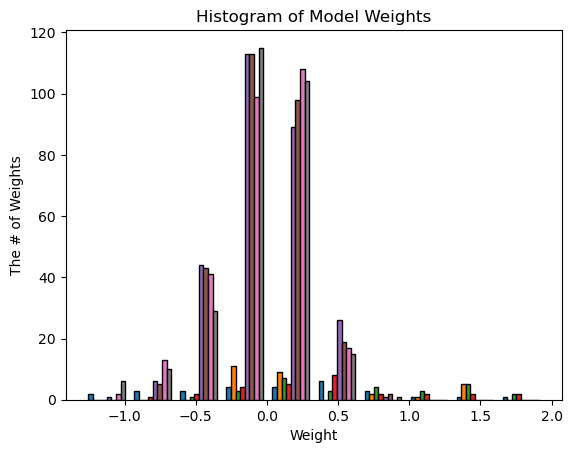

In [58]:

plt.hist(param_arr, bins=10, edgecolor='black') # Plot the histogram with 20 bins and black edges
plt.title('Histogram of Model Weights') # Add title to the plot
plt.xlabel('Weight') # Label the x-axis
plt.ylabel('The # of Weights') # Label the y-axis
plt.show() # Display the plot